# Web attack detection using CICIDS2017 dataset

Training data: "Intrusion Detection Evaluation Dataset" (CICIDS2017). Description page: https://www.unb.ca/cic/datasets/ids-2017.html

The data set is public. Download link: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/

CICIDS2017 combines 8 files recorded on different days of observation (PCAP + CSV). Used archive: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip

In the downloaded archive GeneratedLabelledFlows.zip the file "Thursday" Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv is selected.

Sources:

* [Sharafaldin2018] Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 2018
* [Kostas2018] Kahraman Kostas. Anomaly Detection in Networks Using Machine Learning. 2018 (error was found in assessing the importance of features)
* https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning (error was found in assessing the importance of features)

## Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Download the dataset from Github to Google Colab and unzip it.

In [2]:
!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip -O dataset.zip
!unzip -u dataset.zip

--2020-09-29 07:05:31--  https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15190336 (14M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  14.49M  30.4MB/s    in 0.5s    

2020-09-29 07:05:32 (30.4 MB/s) - ‘dataset.zip’ saved [15190336/15190336]

Archive:  dataset.zip


We use "engine=python" to avoid the "UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 11: invalid start byte" encoding error.

In [3]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python')

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv file contains 458968 records, 85 columns.

In [4]:
df.shape

(458968, 85)

The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.

In [5]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

In [6]:
df['Label'].unique()

array(['BENIGN', 'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', nan], dtype=object)

In [7]:
df['Label'].value_counts()

BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: Label, dtype: int64

Delete blank records.

In [8]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

Replace the NaN values with zeros.

In [9]:
df.fillna(0, inplace=True)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [10]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [11]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [12]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [13]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [14]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [15]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: Label, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:
 
     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [16]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [17]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [18]:
df_balanced['Label'].value_counts()

BENIGN                        5087
Web Attack � Brute Force      1507
Web Attack � XSS               652
Web Attack � Sql Injection      21
Name: Label, dtype: int64

If necessary, we can keep a single class of attack for experiments.

In [19]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [20]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [21]:
df = pd.read_csv('web_attacks_balanced.csv')
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded)

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset. 

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

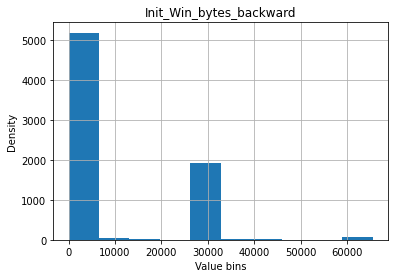

In [22]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

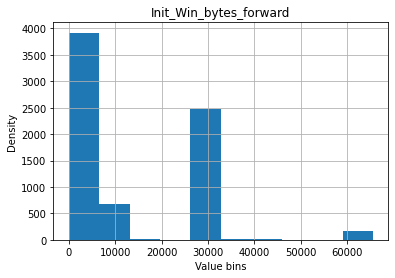

In [23]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [24]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2)

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [25]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


## Feature importance

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3527, 1: 1559}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)
 
In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.
 
By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.94891945, 0.95481336, 0.94499018, 0.94891945, 0.95088409,
       0.94891945, 0.95472441, 0.94094488, 0.96259843, 0.95275591])

In [28]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.57
|   |--- Fwd IAT Std <= 3526476.62
|   |   |--- class: 0
|   |--- Fwd IAT Std >  3526476.62
|   |   |--- Fwd IAT Min <= 15017.00
|   |   |   |--- class: 1
|   |   |--- Fwd IAT Min >  15017.00
|   |   |   |--- class: 0
|--- Packet Length Mean >  0.57
|   |--- Subflow Fwd Bytes <= 35001.00
|   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  35001.00
|   |   |--- class: 1



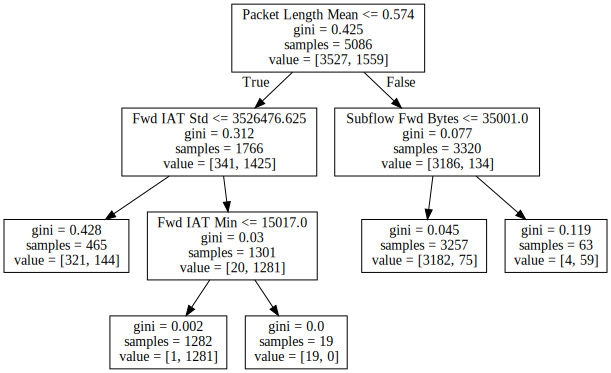

In [29]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

Analyze the confusion matrix. Which classes are confidently classified by the model?

In [30]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1560, 1: 621}

In [31]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1557,    3],
       [  69,  552]])

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [32]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17268669, 0.        , 0.02068535, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.74955962,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05706834, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [33]:
sfm.threshold_

0.01351351351351351

In [34]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [35]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7495596152594705
1.	Fwd IAT Std - 0.17268668878361404
2.	Subflow Fwd Bytes - 0.0570683438976593
3.	Fwd IAT Min - 0.020685352059256014
4.	Idle Min - 0.0
5.	Bwd IAT Std - 0.0
6.	Fwd IAT Mean - 0.0
7.	Fwd IAT Max - 0.0
8.	Bwd IAT Total - 0.0
9.	Bwd IAT Mean - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [37]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices[:20]:
    print('#{}\t{:.3f}\t{}'.format(i, importances[i], features[i]))

#51	0.083	Average Packet Size
#13	0.077	Flow Bytes/s
#38	0.070	Max Packet Length
#39	0.059	Packet Length Mean
#23	0.059	Fwd IAT Min
#7	0.057	Fwd Packet Length Mean
#61	0.048	Subflow Fwd Bytes
#52	0.044	Avg Fwd Segment Size
#3	0.041	Total Length of Fwd Packets
#15	0.033	Flow IAT Mean
#21	0.031	Fwd IAT Std
#5	0.029	Fwd Packet Length Max
#33	0.025	Fwd Header Length
#16	0.024	Flow IAT Std
#14	0.024	Flow Packets/s
#0	0.024	Flow Duration
#35	0.019	Fwd Packets/s
#17	0.017	Flow IAT Max
#19	0.016	Fwd IAT Total
#22	0.016	Fwd IAT Max


For comparison, the results of the study [Sharafaldin2018] (compare relatively, without taking into account the multiplier):
 
* Init Win F.Bytes 0.0200
* Subflow F.Bytes 0.0145
* Init Win B.Bytes 0.0129
* Total Len F.Packets 0.0096

And incorrect results [Kostas2018] (error was found in assessing the importance of features, line: *impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})*, the importances[0:20] sample does not take into account that the values are not sorted in descending order):
 
* Flow Bytes/s 0.313402
* Total Length of Fwd Packets 0.304917
* Flow Duration 0.000485
* Fwd Packet Length Max 0.00013

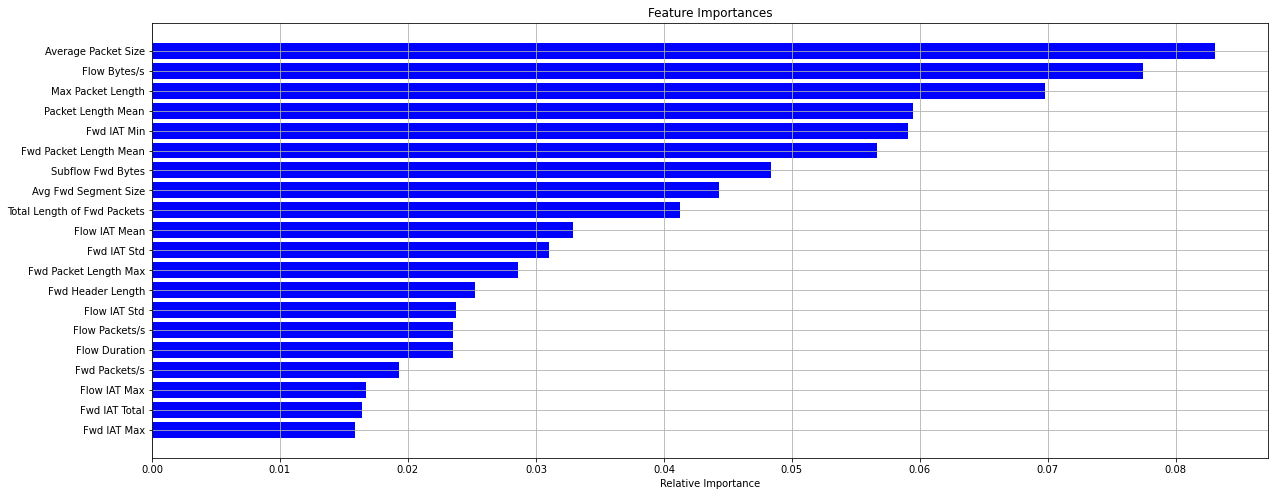

In [38]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (20, 8)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300)
plt.show()

Make sure that SelectFromModel shows the same results.

In [39]:
sfm = SelectFromModel(estimator=rf).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([2.35290102e-02, 7.96680677e-03, 4.06816304e-03, 4.12687835e-02,
       9.83724990e-03, 2.86117483e-02, 2.48283866e-04, 5.66474813e-02,
       3.53334029e-03, 5.55751849e-03, 2.85553825e-04, 3.31992191e-03,
       2.41607686e-03, 7.74179191e-02, 2.35514560e-02, 3.29319669e-02,
       2.37261393e-02, 1.67135759e-02, 1.13381215e-02, 1.64269640e-02,
       1.49298633e-02, 3.10539944e-02, 1.58491178e-02, 5.91057853e-02,
       4.73824075e-03, 4.07708950e-03, 2.49789855e-03, 2.75648040e-03,
       4.89478294e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.52191336e-02, 1.28321800e-02, 1.93303880e-02,
       1.13652236e-02, 3.48623392e-04, 6.97887055e-02, 5.94478376e-02,
       7.62324984e-03, 7.17442130e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.29372392e-02, 7.61039194e-03, 4.35414325e-03,
       0.00000000e+00, 0.00000000e+00, 2.73988037e-03, 8.30468722e-02,
       4.42895749e-02, 4.36227086e-03, 0.00000000e+00, 0.00000000e+00,
      

In [40]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 21


In [41]:
indices = np.argsort(rf.feature_importances_)[::-1]
webattack_features = []
for idx, i in enumerate(indices):
    webattack_features.append(X_train.columns[i])
    if idx < 20:
        print("{}.\t{} - {}".format(idx, X_train.columns[i], rf.feature_importances_[i]))

0.	Average Packet Size - 0.08304687216519575
1.	Flow Bytes/s - 0.07741791914229391
2.	Max Packet Length - 0.0697887054596054
3.	Packet Length Mean - 0.05944783762879627
4.	Fwd IAT Min - 0.05910578531455271
5.	Fwd Packet Length Mean - 0.056647481305229994
6.	Subflow Fwd Bytes - 0.04840312676301025
7.	Avg Fwd Segment Size - 0.04428957486934989
8.	Total Length of Fwd Packets - 0.04126878347802345
9.	Flow IAT Mean - 0.03293196693092254
10.	Fwd IAT Std - 0.031053994393374477
11.	Fwd Packet Length Max - 0.02861174828761524
12.	Fwd Header Length - 0.0252191336331209
13.	Flow IAT Std - 0.02372613932377926
14.	Flow Packets/s - 0.023551455998798442
15.	Flow Duration - 0.02352901024161367
16.	Fwd Packets/s - 0.019330387966376605
17.	Flow IAT Max - 0.01671357585598448
18.	Fwd IAT Total - 0.01642696403867533
19.	Fwd IAT Max - 0.015849117790575712


Once again we analyze the confusion matrix, now for a higher quality classifier. A random forest also badly distinguishes between separate attack classes ("Web Attack – XSS" is very similar to "Web Attack – Brute Force"). At the same time, the "BENIGN" class is well separated from the others.
 
If we combine different attack classes into one "web attack" class, the resulting binary classifier will show high quality.

In [42]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1528,   32],
       [  16,  605]])

Next, for experiments, we keep the first max_features of features with maximum importance.

In [43]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd IAT Min',
 'Fwd Packet Length Mean',
 'Subflow Fwd Bytes',
 'Avg Fwd Segment Size',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Std',
 'Fwd Packet Length Max',
 'Fwd Header Length',
 'Flow IAT Std',
 'Flow Packets/s',
 'Flow Duration',
 'Fwd Packets/s',
 'Flow IAT Max',
 'Fwd IAT Total',
 'Fwd IAT Max']

## Analysis of selected features

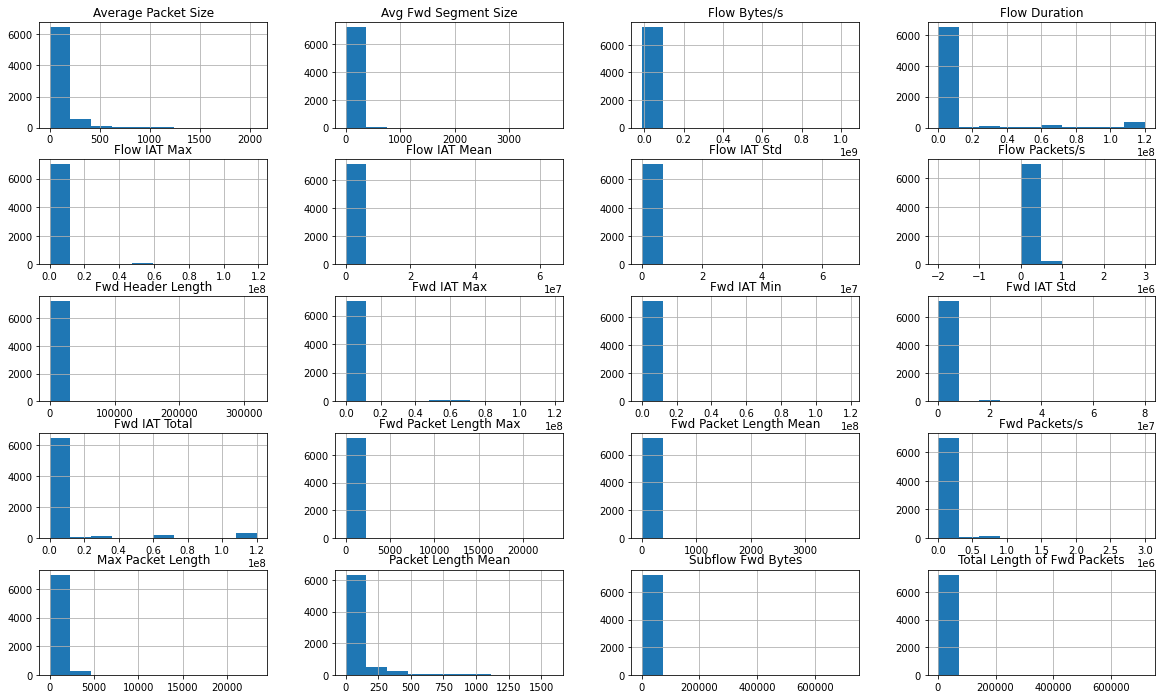

In [44]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

Install Facets Overview

https://pair-code.github.io/facets/

In [45]:
!pip install facets-overview

Create the feature stats for the datasets and stringify it.

In [46]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

Display the facets overview visualization for this data.

In [47]:
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


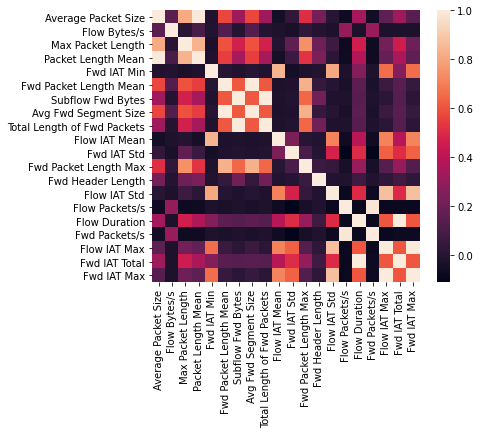

In [48]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix);
plt.savefig('corr_heatmap.png', dpi=300)

Remove correlated features.

In [49]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes', 'Fwd Packets/s', 'Fwd IAT Total'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Fwd IAT Min',
 'Fwd Packet Length Mean',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Std',
 'Fwd Packet Length Max',
 'Fwd Header Length']

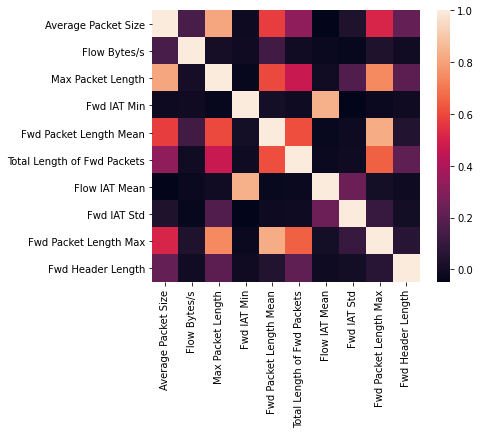

In [50]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix);

## Hyperparameter selection

Reopen the dataset.

In [51]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else (0 if random.random() < 0 else 1))
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


We get the list of RandomForestClassifier parameters.

In [52]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [53]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

CPU times: user 9.96 s, sys: 13.5 ms, total: 9.97 s
Wall time: 9.98 s


In [54]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,split7_train_f1,split8_train_f1,split9_train_f1,mean_train_f1,std_train_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.029302,0.00379,0.003388,0.000291,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.866972,0.835443,0.827004,0.853448,0.848485,0.842553,0.855263,0.889353,0.887029,0.821577,0.852713,0.021864,15,0.851144,0.854558,0.855511,0.852529,0.853074,0.853746,0.852335,0.848427,0.848701,0.856189,0.852621,0.00248,0.92022,0.89271,0.887208,0.906465,0.903714,0.898212,0.909216,0.926997,0.92562,0.881543,0.90519,0.014919,15,0.903517,0.906575,0.907187,0.905046,0.905352,0.905963,0.90474,0.902767,0.90292,0.907812,0.905188,0.001657


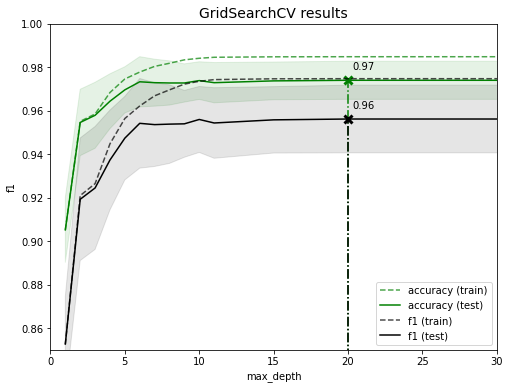

In [55]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 6))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(0, 30)
ax.set_ylim(0.85, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

### Grid search

In [56]:
parameters = {'n_estimators': [50, 100], 
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10], 
              'max_depth': [17, 23]}

parameters = {'n_estimators': [100], 'max_features': [10]}

In [57]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

CPU times: user 15.1 s, sys: 19.4 ms, total: 15.1 s
Wall time: 15.1 s


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                  

Let's take a look at the results of the parameter selection.

In [58]:
gcv.best_estimator_ 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [59]:
gcv.best_params_

{'max_features': 10, 'n_estimators': 100}

In [60]:
gcv.best_score_

0.9557574450584504

## Final model

In [61]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [62]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices[:10]:
    print('#{}\t{:.3f}\t{}'.format(i, importances[i], features[i]))

#2	0.318	Max Packet Length
#3	0.217	Fwd IAT Min
#0	0.204	Average Packet Size
#7	0.107	Fwd IAT Std
#5	0.047	Total Length of Fwd Packets
#6	0.044	Flow IAT Mean
#9	0.038	Fwd Header Length
#4	0.016	Fwd Packet Length Mean
#8	0.007	Fwd Packet Length Max
#1	0.002	Flow Bytes/s


Train the model on our own dataset.

In [63]:
!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/mix_labelled.zip -O mix_labelled.zip
!unzip -u mix_labelled.zip

--2020-09-29 07:07:13--  https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/mix_labelled.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95046 (93K) [application/zip]
Saving to: ‘mix_labelled.zip’

mix_labelled.zip    100%[===================>]  92.82K  --.-KB/s    in 0.03s   

2020-09-29 07:07:13 (2.89 MB/s) - ‘mix_labelled.zip’ saved [95046/95046]

Archive:  mix_labelled.zip


In [64]:
df = pd.read_csv('mix_labelled.csv')
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(1407, 10) (1407,)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(984, 10) (984,)
(423, 10) (423,)


In [67]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [68]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[138,  53],
       [  4, 228]])

In [69]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

Precision = 0.8113879003558719
Recall = 0.9827586206896551
F1 = 0.8888888888888888
Accuracy = 0.8652482269503546


## Model saving

In [70]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(gcv.best_estimator_, f)

## Model approbation

Open the previously saved model.

In [71]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Reopen the dataset.

In [72]:
df = pd.read_csv('web_attacks_balanced.csv')
# df = pd.read_csv('mix_labelled.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(7267, 10) (7267,)


In [73]:
X_test.head()

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd IAT Min,Fwd Packet Length Mean,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Fwd Header Length
0,72.000000,3.162889e+03,48.0,0.0,48.0,48.0,3.035200e+04,0.000000e+00,48.0,32.0
1,80.000000,1.408163e+06,94.0,49.0,44.0,88.0,6.533333e+01,0.000000e+00,44.0,64.0
2,50.400000,8.718178e+00,48.0,1998856.0,48.0,480.0,5.795513e+06,2.000000e+07,48.0,236.0
3,35.071429,4.667300e+05,163.0,1.0,16.5,165.0,8.092308e+01,2.054254e+02,79.0,336.0
4,94.250000,2.024845e+06,112.0,3.0,51.0,102.0,5.366667e+01,0.000000e+00,51.0,64.0


In [74]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.0606236457824707 seconds
Benign records detected (0), attacks detected (1):


{0: 5069, 1: 2198}

Confusion matrix:

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

In [75]:
confusion_matrix(y_test, y_pred)

array([[5034,   53],
       [  35, 2145]])

In [76]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

Precision = 0.9758871701546861
Recall = 0.9839449541284404
F1 = 0.9798994974874372
Accuracy = 0.9878904637401954


Manual calculation of the confusion matrix:
    
    array([[5075,   12],
           [   1, 2179]], dtype=int64)
  
      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

    Точность
    Precision = TP / (TP + FP) = 2179 / (2179 + 12) = 0.9945230488361478

    Полнота
    Recall = TP / (TP + FN) = 2179 / (2179 + 1) = 0.9995412844036697

    F-мера, параметр = 1, гармоническое среднее точности и полноты, множитель = 2
    F1 = 2 * (precision * recall) / (precision + recall) = 0.9970258522077328

    Доля правильных ответов
    Accuracy = TP + TN / (TP + TN + FP + FN) = (2179 + 5075) / 7267 = 0.998211091234347

In [77]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [78]:
result[result['Predict'] == 1]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd IAT Min,Fwd Packet Length Mean,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Fwd Header Length,Label,Predict
172,0.000000,0.000000,0.0,0.0,0.000000,0.0,46.0000,0.000000e+00,0.0,32.0,0,1
178,0.000000,0.000000,0.0,0.0,0.000000,0.0,45.0000,0.000000e+00,0.0,32.0,0,1
409,238.785714,644.729782,1047.0,4.0,146.000000,1022.0,398855.2308,5.614102e+04,372.0,232.0,1,1
410,624.470588,2099.113097,4344.0,192.0,73.600000,736.0,316085.8750,1.650529e+06,395.0,328.0,1,1
412,199.916667,455.121233,1066.0,323.0,138.428571,969.0,479193.0000,2.003103e+06,561.0,232.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6951,0.000000,0.000000,0.0,0.0,0.000000,0.0,51.0000,0.000000e+00,0.0,32.0,0,1
7009,0.000000,0.000000,0.0,0.0,0.000000,0.0,66.0000,0.000000e+00,0.0,32.0,0,1
7048,0.000000,0.000000,0.0,0.0,0.000000,0.0,79.0000,0.000000e+00,0.0,32.0,0,1
7123,0.000000,0.000000,0.0,0.0,0.000000,0.0,21.0000,0.000000e+00,0.0,32.0,0,1


In [79]:
result[410:430]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd IAT Min,Fwd Packet Length Mean,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Fwd Header Length,Label,Predict
410,624.470588,2.099113e+03,4344.0,192.0,73.600000,736.0,3.160859e+05,1.650529e+06,395.0,328.0,1,1
411,0.000000,0.000000e+00,0.0,0.0,0.000000,0.0,8.100000e+01,0.000000e+00,0.0,32.0,1,0
412,199.916667,4.551212e+02,1066.0,323.0,138.428571,969.0,4.791930e+05,2.003103e+06,561.0,232.0,1,1
413,22.666667,5.692308e+05,31.0,1.0,15.500000,31.0,3.250000e+01,0.000000e+00,31.0,64.0,0,0
414,0.000000,0.000000e+00,0.0,0.0,0.000000,0.0,1.300000e+01,0.000000e+00,0.0,32.0,0,0
415,0.000000,0.000000e+00,0.0,0.0,0.000000,0.0,3.600000e+01,0.000000e+00,0.0,32.0,0,0
416,218.454545,4.786244e+02,1066.0,18.0,139.000000,973.0,5.020638e+05,2.021330e+06,565.0,232.0,1,1
417,10.333333,1.016393e+05,31.0,47.0,10.333333,31.0,1.525000e+02,1.491995e+02,31.0,96.0,0,0
418,121.500000,2.075472e+06,174.0,4.0,46.000000,92.0,7.066667e+01,0.000000e+00,46.0,64.0,0,0
419,9.000000,1.764706e+05,6.0,0.0,6.000000,6.0,6.800000e+01,0.000000e+00,6.0,20.0,0,0
